# Molpher-lib

New features in the `0.0.0b2dev0` development snapshot.

Initialization of a molecule using a string representation (SMILES and SDF file path are two recognized types at the moment):

In [1]:
from molpher.core import MolpherMol

cymene_smiles = MolpherMol("CC1=CC=C(C(C)C)C=C1")
print(cymene_smiles.smiles)
cymene_sdf = MolpherMol("cymene.sdf") # if the string ends with '.sdf', the library interprets it as a path to a file
print(cymene_sdf.smiles)

CC1=CC=C(C(C)C)C=C1
CC1=CC=C(C(C)C)C=C1


For convenience, it is possible to readily convert the `MolpherMol` molecule to an RDKit `Mol`:

<class 'rdkit.Chem.rdchem.Mol'>


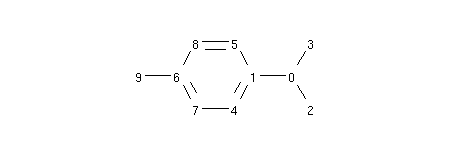

In [2]:
# imports that will enable direct display of RDKit molecules
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
IPythonConsole.ipython_useSVG = False
DrawingOptions.includeAtomNumbers = True

cymene_rdkit = cymene_sdf.asRDMol()
print(cymene_rdkit.__class__)
cymene_rdkit

We can also convert the RDKit molecule back to a `MolpherMol` instance using the `other` parameter of the `MolpherMol` class:

In [3]:
MolpherMol(other=cymene_rdkit).smiles

'CC1=CC=C(C(C)C)C=C1'

The constructor will automatically recognize an rdkit `Mol` instance and do all the necessary steps to convert it. We can also just supply another `MolpherMol` instead:

In [4]:
MolpherMol(other=cymene_smiles).smiles

'CC1=CC=C(C(C)C)C=C1'

The code will again do the introspection and perform the necessary steps.

This behaviour will probably change a little in the future. Static factory methods will be more sensible for the task since there is a plethora of different representations that can be used to initialize molecules.

# Atom locking

The structure of cymene that we loaded through an SDF file has some of its atoms locked for certain modifications:

In [5]:
with open("cymene.sdf", "r") as cymene_file:
    print(cymene_file.read())

7463
  -OEChem-06091704012D

 24 24  0     0  0  0  0  0  0999 V2000
    2.8660    1.7500    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.8660    0.7500    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.7320    2.2500    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.0000    2.2500    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.0000    0.2500    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.7320    0.2500    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.8660   -1.2500    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.0000   -0.7500    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.7320   -0.7500    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.8660   -2.2500    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.8660    2.3700    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0
    4.0420    1.7131    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0
    4.2690    2.5600    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0
    3.4220    2.7869 

The locked atoms are indicated in the SDF as molecule properties. Each property name starts with a prefix `MOLPHER_` continued by a 'lock name' which indicates what kind of locking mechanism should be employed. The value of the property is a list of atom numbers that indicates what atoms should be locked in the specified manner. In our example, we decided to forbid addition of new atoms to atoms 2,5,6,7,8 and 9 and we also disabled their removal. Atom number 10 should also not be removed from the molecule during morphing.

It is possible to easily get a hold of the locked atoms in the molecule using a function like this:

In [6]:
def get_locked_atoms(mol):
    return [(idx, atm) for idx, atm in enumerate(mol.atoms) if atm.is_locked]

locked_atoms = get_locked_atoms(cymene_sdf)
locked_atoms

[(1, <molpher.core.MolpherAtom.MolpherAtom at 0x7f2daaee66f0>),
 (4, <molpher.core.MolpherAtom.MolpherAtom at 0x7f2daaee67e0>),
 (5, <molpher.core.MolpherAtom.MolpherAtom at 0x7f2daaee6810>),
 (6, <molpher.core.MolpherAtom.MolpherAtom at 0x7f2daaee6840>),
 (7, <molpher.core.MolpherAtom.MolpherAtom at 0x7f2daaee6870>),
 (8, <molpher.core.MolpherAtom.MolpherAtom at 0x7f2daaee68a0>),
 (9, <molpher.core.MolpherAtom.MolpherAtom at 0x7f2daaee68d0>)]

The list contains tuples where the first member is the index of the atom in the molecule and the second is an instance of `MolpherAtom`, a class used to represent atoms in the Molpher-lib library. `MolpherAtom` instances can be used to query lock information and other atom-related data. If we convert the molecule to an RDKit instance, the atom locks are saved as properties of the molecule:

In [7]:
cymene_rdkit.GetPropsAsDict()

{'MOLPHER_NO_ADDITION': '2,5,6,7,8,9', 'MOLPHER_NO_REMOVAL': '2,5,6,7,8,9,10'}

I think that atoms in RDKit can have properties as well so in the future, the locking information will probably be written directly to the atoms as well as to the molecule as a whole.

So far the actual position of the locked atoms in the molecule has been rather hidden from us so let's take a look now. The following function displays the structure and highlights the locked atoms for us:

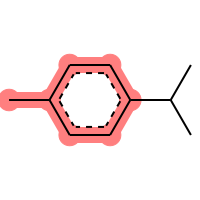

In [8]:
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

def show_locked_atoms(mol):
    drawer = rdMolDraw2D.MolDraw2DSVG(200, 200)
    drawer.DrawMolecule(
        mol.asRDMol()
        , highlightAtoms=[x[0] for x in get_locked_atoms(mol)]
    )
    drawer.FinishDrawing()
    return drawer.GetDrawingText().replace('svg:','')

SVG(show_locked_atoms(cymene_sdf))

This works because the order of atoms is the same in the generated RDKit molecule and the original `MolpherMol` instance.

In order to get an overview of different locks placed on each atom, we can use the `lock_info` attribute of `MolpherAtom`:

In [9]:
for atm in locked_atoms:
    print(atm[1].lock_info)

{'UNLOCKED': False, 'NO_MUTATION': False, 'NO_ADDITION': True, 'NO_REMOVAL': True, 'KEEP_NEIGHBORS': False, 'KEEP_NEIGHBORS_AND_BONDS': False, 'KEEP_BONDS': False, 'FULL_LOCK': False}
{'UNLOCKED': False, 'NO_MUTATION': False, 'NO_ADDITION': True, 'NO_REMOVAL': True, 'KEEP_NEIGHBORS': False, 'KEEP_NEIGHBORS_AND_BONDS': False, 'KEEP_BONDS': False, 'FULL_LOCK': False}
{'UNLOCKED': False, 'NO_MUTATION': False, 'NO_ADDITION': True, 'NO_REMOVAL': True, 'KEEP_NEIGHBORS': False, 'KEEP_NEIGHBORS_AND_BONDS': False, 'KEEP_BONDS': False, 'FULL_LOCK': False}
{'UNLOCKED': False, 'NO_MUTATION': False, 'NO_ADDITION': True, 'NO_REMOVAL': True, 'KEEP_NEIGHBORS': False, 'KEEP_NEIGHBORS_AND_BONDS': False, 'KEEP_BONDS': False, 'FULL_LOCK': False}
{'UNLOCKED': False, 'NO_MUTATION': False, 'NO_ADDITION': True, 'NO_REMOVAL': True, 'KEEP_NEIGHBORS': False, 'KEEP_NEIGHBORS_AND_BONDS': False, 'KEEP_BONDS': False, 'FULL_LOCK': False}
{'UNLOCKED': False, 'NO_MUTATION': False, 'NO_ADDITION': True, 'NO_REMOVAL': Tru

The different locks are available as constant members of the `MolpherAtom` class and can be easily combined with bit operators. The following code example adds a new lock to atom \#2 (index 1):

In [10]:
from molpher.core import MolpherAtom

locked_atoms[0][1].locking_mask = locked_atoms[0][1].locking_mask | MolpherAtom.KEEP_NEIGHBORS_AND_BONDS

All locks are saved in the `locking_mask` property. You can always transform this property to a list of lock names using the `lockingMaskToString` static method:

In [11]:
MolpherAtom.lockingMaskToString(locked_atoms[0][1].locking_mask)

('NO_ADDITION',
 'NO_REMOVAL',
 'KEEP_NEIGHBORS',
 'KEEP_NEIGHBORS_AND_BONDS',
 'KEEP_BONDS')

or you can look at the `lock_info` again:

In [12]:
print(cymene_sdf.getAtom(1).lock_info)

{'UNLOCKED': False, 'NO_MUTATION': False, 'NO_ADDITION': True, 'NO_REMOVAL': True, 'KEEP_NEIGHBORS': True, 'KEEP_NEIGHBORS_AND_BONDS': True, 'KEEP_BONDS': True, 'FULL_LOCK': False}


You can see that the `KEEP_NEIGHBORS` and `KEEP_BONDS` locks were also automatically added to the atom since the lock we set is basically a combination of the two. `KEEP_NEIGHBORS` will ensure that the neighboring atoms will not be changed or removed while `KEEP_BONDS` will prevent any changes to the bonds that this atom contributes to.

Let's now redefine the `show_locked_atoms` function above so that we can display atoms that have specific locks on them:

In [13]:
def show_locked_atoms(mol, mask = MolpherAtom.FULL_LOCK):
    drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)
    drawer.DrawMolecule(
        mol.asRDMol()
        , highlightAtoms=[x[0] for x in get_locked_atoms(mol) if (x[1].locking_mask & mask) != 0]
    )
    drawer.FinishDrawing()
    return drawer.GetDrawingText().replace('svg:','')

This function will by default again simply highlight atoms that have any locks in place since the `FULL_LOCK` lock combines all locks into one:

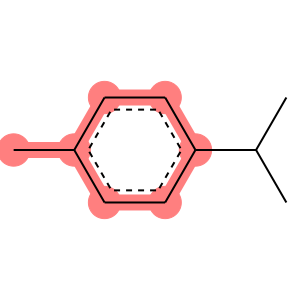

In [14]:
SVG(show_locked_atoms(cymene_sdf))

If we want to highlight specific locks, we can easily do so by supplying the associated value:

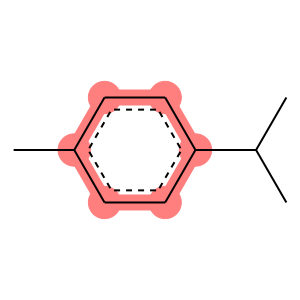

In [15]:
SVG(show_locked_atoms(cymene_sdf, MolpherAtom.NO_ADDITION))

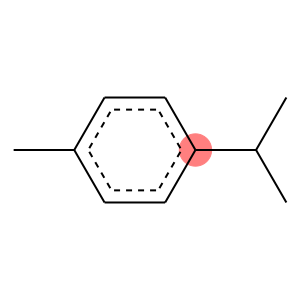

In [16]:
SVG(show_locked_atoms(cymene_sdf, MolpherAtom.KEEP_NEIGHBORS_AND_BONDS))

Let's now use a morphing operator to generate a random morph of this molecule:

In [17]:
from molpher.core.morphing.operators import AddAtom

add_atom = AddAtom()
add_atom.setOriginal(cymene_sdf)
morph = add_atom.morph()
print(morph.smiles)

CCC(C)C1=CC=C(C)C=C1


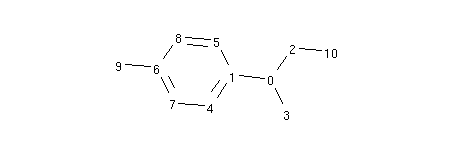

In [18]:
morph.asRDMol()

In short, the `AddAtom` operator basically selects a random atom in the molecule (as allowed by the placed locks) and then adds a random atom to it.

Therefore, we get a different result each time we run the `morph` method:

In [19]:
morphs = [add_atom.morph() for i in range(10)]
[x.smiles for x in morphs]

['CC1=CC=C(C(C)(C)C)C=C1',
 'CC1=CC=C(C(C)CS)C=C1',
 'CC1=CC=C(C(C)(C)C)C=C1',
 'CC1=CC=C(C(C)CS)C=C1',
 'CC1=CC=C(C(C)CN)C=C1',
 'CC1=CC=C(C(C)CBr)C=C1',
 'CC1=CC=C(C(C)(C)Br)C=C1',
 'CC1=CC=C(C(C)(C)S)C=C1',
 'CC1=CC=C(C(C)CI)C=C1',
 'CC(C)C1=CC=C(CBr)C=C1']

We can easily display the created morphs like so:

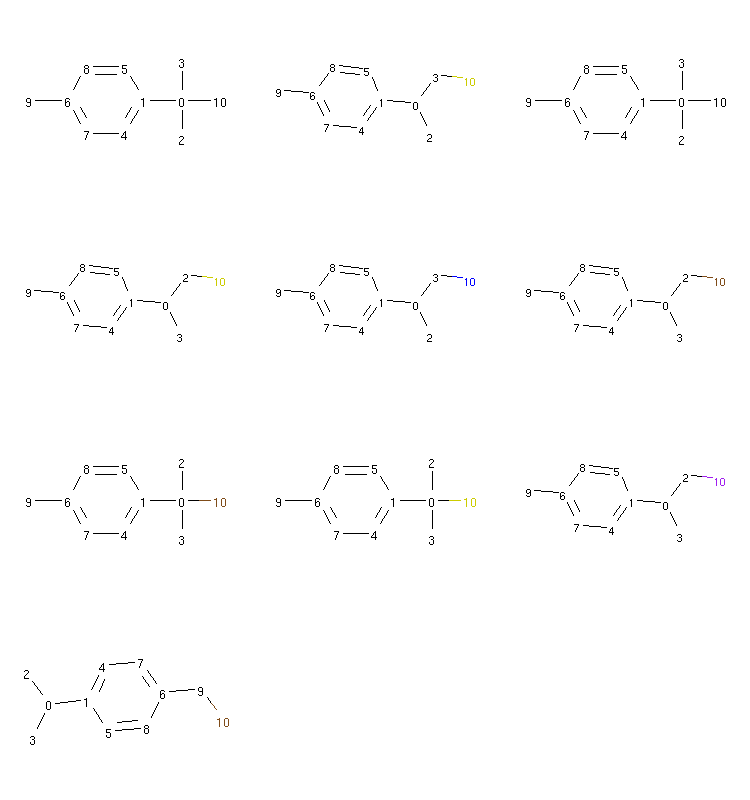

In [20]:
from rdkit.Chem.Draw import MolsToGridImage

def show_mol_grid(mols):
    return MolsToGridImage(
        [x.asRDMol() for x in morphs]
        ,subImgSize=(250,200)
    )

show_mol_grid(morphs)

You can see that the code respects the constraints we specified and that no atoms are added to the aromatic ring system. Therefore, we essentially explored a part of chemical space around a certain scaffold.

We could also generate a simple random path in chemical space with this operator:

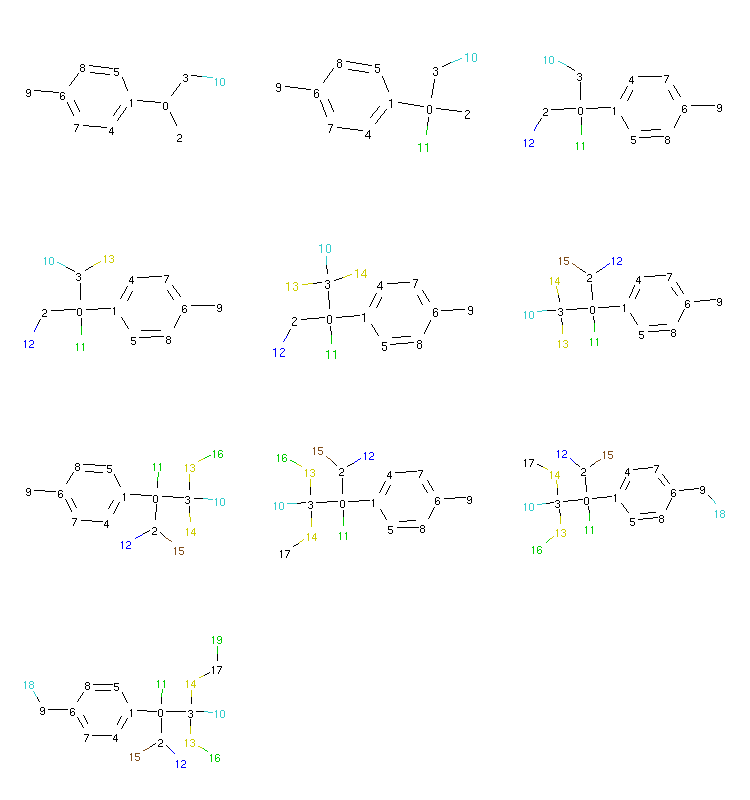

In [21]:
add_atom.setOriginal(cymene_sdf)
morphs = []
for iter in range(10):
    morph = add_atom.morph()
    if morph:
        morphs.append(morph)
        add_atom.setOriginal(morph)

show_mol_grid(morphs)

Now these molecules are obviously rather crazy since the probability of adding an atom of certain type is the same for all of them at the moment, but there will be a mechanism to affect the ratio in which the added types are selected in the future. 

If we were only interested in adding carbon or just a handful of types, we could define our own atom library and make the `AddAtom` operator use it:

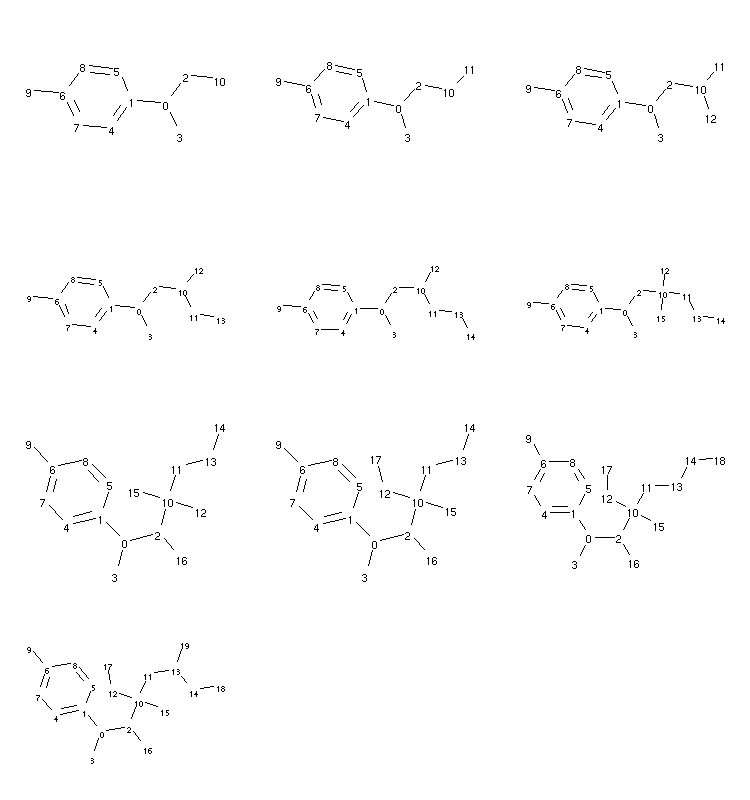

In [22]:
from molpher.core.morphing import AtomLibrary

my_lib = AtomLibrary(["C"])
add_atom = AddAtom(my_lib)

add_atom.setOriginal(cymene_sdf)
morphs = []
for iter in range(10):
    morph = add_atom.morph()
    if morph:
        morphs.append(morph)
        add_atom.setOriginal(morph)

show_mol_grid(morphs)

The `AddAtom` class will have more features in the future to customize the atoms that can be added and in what ratio. This is just a simple example to show how morphing could work using a single operator.

It should also be noted that the placed atom locks are preserved during morphing. Let's modify our display function to also highlight locking information:

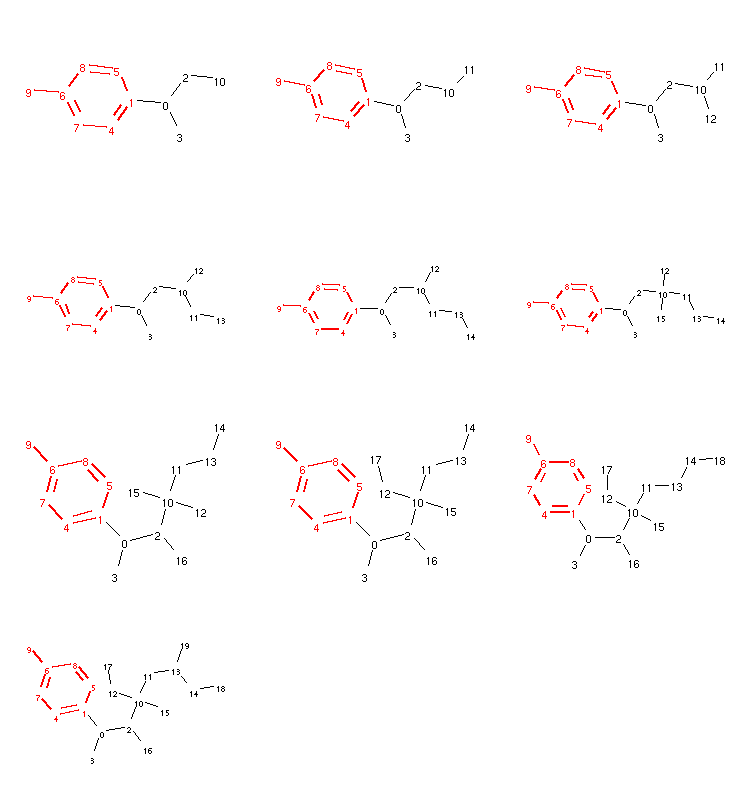

In [23]:
def show_mol_grid(mols):
    locked_atoms = [[y[0] for y in get_locked_atoms(x)] for x in morphs]
    return MolsToGridImage(
        [x.asRDMol() for x in morphs]
        , subImgSize=(250,200)
        , highlightAtomLists=locked_atoms
    )

show_mol_grid(morphs)

Let's now showcase the `Molpher` class which brings all operators together:

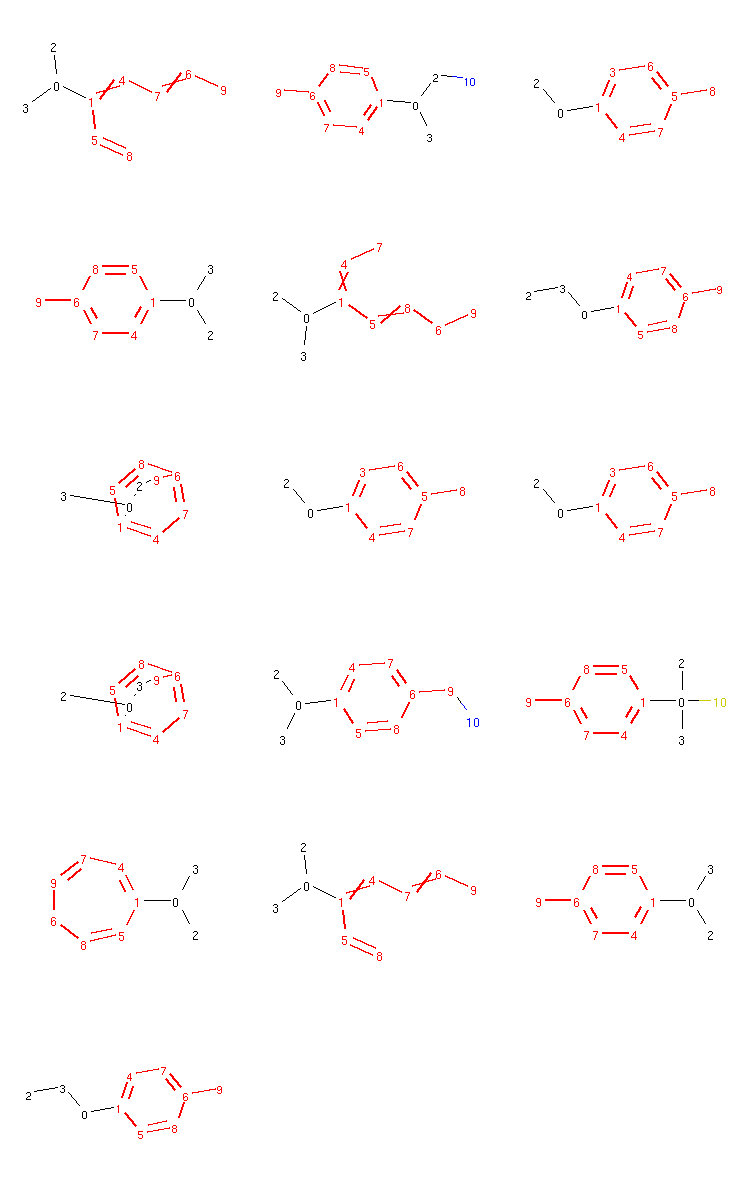

In [24]:
from molpher.core.morphing.operators import *
from molpher.core.morphing import Molpher

operators = [
    AddAtom()
    , AddBond()
    , ContractBond()
    , InterlayAtom()
    , MutateAtom()
    , RemoveBond()
    , RerouteBond()
    , RemoveAtom()
]
molpher = Molpher(cymene_sdf, operators, attempts=20)
molpher()
morphs = molpher.getMorphs()
show_mol_grid(morphs)

Using all operators obviously can break the aromatic core sometimes since we did not fully protect it against bond breaking and other modifications, but we could easily achieve that by introducing suitable locks, such as `KEEP_NEIGHBORS` and/or `KEEP_BONDS`.

The `attempts` parameter in the molpher class constructor specifies how many morphing attempts the class should perform. Since some operators might not be possible on the given molecules, the number of returned morphs can be smaller than the number of attempts. You can see information about the failed attempts in the error log if there were any. 

The class also doesn't keep track of already generated molecules so duplicates can occur. This is the task of the `ExplorationTree` class which  is part of more high level morphing interface and was already described in [previous versions](https://lich-uct.github.io/molpher-lib/v0.0.0b1/usage/tutorial.html#creating-an-exploration-tree-and-setting-morphing-parameters).

The `Molpher` class runs in multithreaded mode and will try to use all available cores on the system. You can change this behaviour with the `threads` constructor parameter (you might need to run it with more attempts and more complex molecules to really see any noticable difference).

It is also possible to use `Molpher` instances as infinite morph generators:

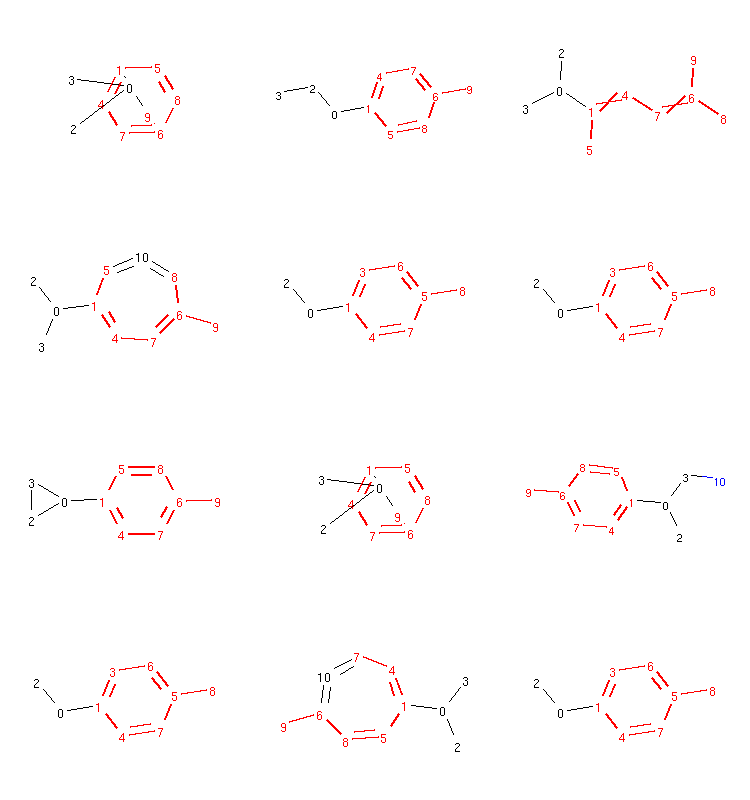

In [25]:
morphs = []
for idx, morph in enumerate(molpher):
    if idx == 12: # this loop is infinite so we stop after 50 morphs
        break
    morphs.append(morph)

show_mol_grid(morphs)

## Custom Morphing Operators

Because all operator classes are required to implement the `MorphingOperator` interface, making a customized operator is possible by just defining a class tha implements the required methods (`setOriginal` and `morph`):

In [26]:
from rdkit import Chem
from molpher.core.morphing.operators import MorphingOperator
import random

class IntroduceNitrogen(MorphingOperator):

    def setOriginal(self, mol):
        super(IntroduceNitrogen, self).setOriginal(mol)
        
        # generate candidates for the replacement
        candidates = Chem.ReplaceSubstructs(
            self.original.asRDMol(include_locks=False), 
            Chem.MolFromSmiles('C'), 
            Chem.MolFromSmiles('N'),
            replaceAll=False
        )
        
        # filter potential nonsence molecules
        viable = []
        for x in candidates:
            try:
                Chem.rdmolops.SanitizeMol(x)
                viable.append(x)
            except ValueError:
                continue
        
        self.candidates = viable

    def morph(self):
        return MolpherMol(other=self.candidates[random.randint(0, len(self.candidates)-1)])

The `IntroduceNitrogen` class in this example is rather simple and basically replaces a random carbon atom in the original structure with a nitrogen. But we could definitely imgine more complex logic here that also takes atom locking into account and other things.

Finally, let's plug this class into a slightly modified version of the morphing code we described above and see if it works:

RDKit ERROR: [18:38:13] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit ERROR: 
RDKit ERROR: [18:38:13] Can't kekulize mol.  Unkekulized atoms: 1 4 5 6 7
RDKit ERROR: 


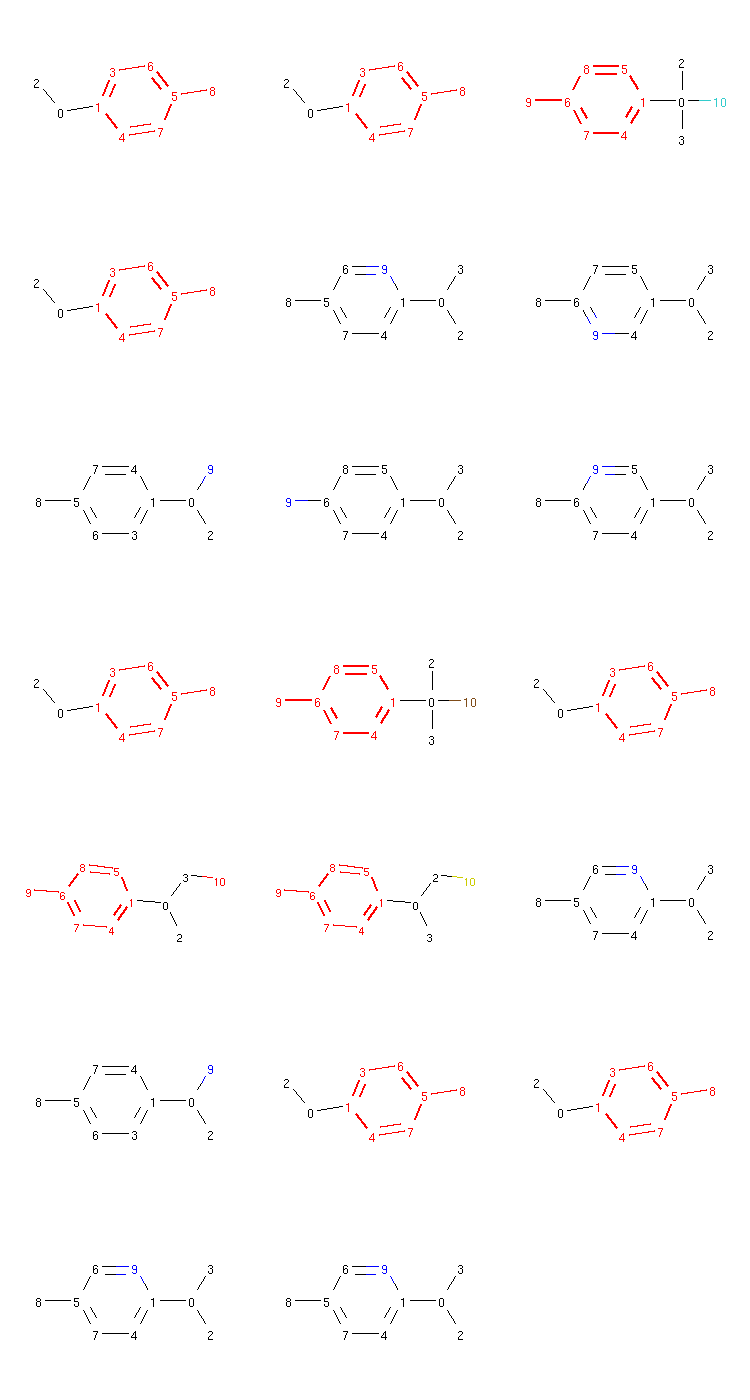

In [27]:
operators = [
    AddAtom()
    , RemoveAtom()
    , IntroduceNitrogen()
]
molpher = Molpher(cymene_sdf, operators, attempts=20)
molpher()
morphs = molpher.getMorphs()
show_mol_grid(morphs)

And indeed apart from other expected products of the transformation we also got a few molecules that have a carbon atom replaced for nitrogen. It should be noted that in this case we could also achieve a similar result with just using the `MutateAtom` operator with a custom atom library. Also note that the structures generated with out operator do not preserver atom locks at the moment, which is something we omitted here for the sake of simplicity.

# Summary

- This short demonstration shows some of the newest Molpher-lib features that are to be included in the next beta.
- There is still plenty of work to be done on the individual operators and their implementing classes -> molpher can generate a lot of chemical nonsence so if we can somehow avoid it by better operator implementation, it would make the whole exploration much more effective
- The `ExplorationTree` class needs to be changed to work with the new interface so that large scale chemical space exploration is also possible with the new features.